In [1]:
import artm
artm.version()

'0.9.2'

In [2]:
import codecs
import os
import nltk

In [3]:
from tqdm import tqdm

In [4]:
import pandas as pd
import re


from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

In [5]:
df_text = pd.read_csv(
    "/Users/Mikhail_Bulgakov/GitRepo/topic-modeling/data/clean_text_preprocessed_lemma_.csv"
)
df_text.head(2)

,Unnamed: 0,clean_text_array_norm
0,41971,все приветделяться вы очередной открытый урок ...
1,32826,ученый священный объект это единственный тщате...


In [6]:
def is_latin_character_in_word(word):
    return len(re.findall(r"[\x00-\x7f]", word)) > 0

def is_non_latin_character_in_word(word):
    return len(re.findall(r"[^\x00-\x7f]", word)) > 0

def is_mixed_characters_in_word(word):
    return (len(re.findall(r"[^\x00-\x7f]", word)) > 0) and (len(re.findall(r"[\x00-\x7f]", word)) > 0)

def leave_russian(string):
    return [word for word in string.split(" ") if (not is_latin_character_in_word(word) and not is_mixed_characters_in_word(word) and len(word) > 1)]

def leave_non_russian(string):
    return [word for word in string.split(" ") if (is_latin_character_in_word(word) and not is_mixed_characters_in_word(word) and len(word) > 1)]

In [7]:
df_text["only_rus"] = df_text["clean_text_array_norm"].apply(leave_russian)

In [8]:
df_text.head(2)

,Unnamed: 0,clean_text_array_norm,only_rus
0,41971,все приветделяться вы очередной открытый урок ...,"[все, приветделяться, вы, очередной, открытый,..."
1,32826,ученый священный объект это единственный тщате...,"[ученый, священный, объект, это, единственный,..."


In [16]:
path='/Users/Mikhail_Bulgakov/GitRepo/topic-modeling/data/bigartm'
f=open(path+'/clean_text_preprocessed_lemma_vowpal_wabbit.txt','a')
x=[]
y=[]
s=[]

In [17]:
lema=df_text["only_rus"].to_list()

100%|█████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1561.89it/s]


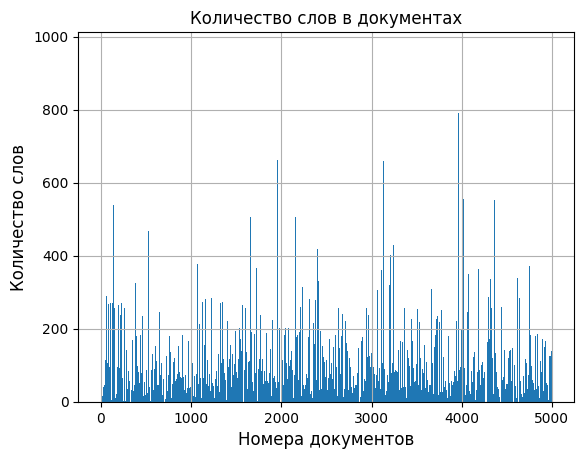

In [18]:
for i in tqdm(range(len(lema))):
    freq=nltk.FreqDist(lema[i])
    z=[]# обновление списка для нового документа
    z=[(key+":"+str(val)) for key,val in freq.items() if val>1] # частота упоминания через : от слова    
    f.write("|text" +" "+(" ").join(z)+'\n')# запись в мешок слов с меткой |text          
    c=[];d=[]
    for key,val in freq.items():#подготовка к сортировке слов по убыванию частоты в i -м документе
        if val>1:
              c.append(val); d.append(key)
    a=[];b=[]    
    for k in np.arange(0,len(c),1):#сортировка слов по убыванию частоты в i -м документе 
        ind=c.index(max(c));  a.append(c[ind])
        b.append(d[ind]); del c[ind]; del d[ind]
    x.append(i)#список номеров документов
    y.append(len(a))#список количества слов в документах     
    # a=a[0:10];b=b[0:10]# TOP-10 для частот a  и слов b в i -м документе    
    # y_pos = np.arange(1,len(a)+1,1)#построение TOP-10 диаграмм      
    # performance =a
    # plt.barh(y_pos, a)
    # plt.yticks(y_pos, b)
    # plt.xlabel(u'Количество слов')
    # plt.title(u'Частоты слов в документе № %i'%i, size=12)
    # plt.grid(True)
    # plt.show()         
plt.title(u'Количество слов в документах', size=12)
plt.xlabel(u'Номера документов', size=12)
plt.ylabel(u'Количество слов', size=12)
plt.bar(x,y, 1)
plt.grid(True)
plt.show()
f.close()  

In [133]:
# создание частотной матрицы из batch
batch_vectorizer = artm.BatchVectorizer(data_path=path+'/clean_text_preprocessed_lemma_vowpal_wabbit.txt',# путь к "мешку слов"
                                        data_format='vowpal_wabbit', # формат данных
                                        target_folder=path+'/batches', # папка с частотной матрицей из batch
                                        batch_size=64)# количество документов в одном batch

In [134]:
dictionary = artm.Dictionary(data_path=path+'/batches')# загрузка данных в словарь
model = artm.ARTM(num_topics=10,
                  num_document_passes=20,#10 проходов по документу
                  dictionary=dictionary,
                  scores=[artm.TopTokensScore(name='top_tokens_score', num_tokens=30)])

In [135]:
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=20)#10 проходов по коллекции
top_tokens = model.score_tracker['top_tokens_score'].last_tokens
top_weights = model.score_tracker['top_tokens_score'].last_weights

In [136]:
e = []
for topic_name in model.topic_names:
    e.append({"words": top_tokens[topic_name],
              "weights": top_weights[topic_name]})

In [137]:
artm_df = pd.DataFrame(e)

In [138]:
artm_df

,words,weights
0,"[который, использовать, данный, код, файл, это...","[0.02229641005396843, 0.01682472787797451, 0.0..."
1,"[год, компания, который, это, свой, рынок, дан...","[0.026388421654701233, 0.025732090696692467, 0..."
2,"[это, человек, который, свой, работа, очень, м...","[0.035799894481897354, 0.019420981407165527, 0..."
3,"[система, который, работа, решение, данный, пр...","[0.021672651171684265, 0.017441684380173683, 0..."
4,"[год, это, который, процессор, память, такой, ...","[0.014560877345502377, 0.014034586027264595, 0..."
5,"[который, это, устройство, камера, сигнал, пла...","[0.014643697999417782, 0.011998020112514496, 0..."
6,"[который, это, пользователь, сервер, сеть, нас...","[0.01616150140762329, 0.012756786309182644, 0...."
7,"[это, который, код, запрос, работать, наш, дан...","[0.03451553359627724, 0.022602135315537453, 0...."
8,"[который, приложение, это, пользователь, игра,...","[0.0243047084659338, 0.02194565162062645, 0.02..."
9,"[это, который, один, такой, каждый, значение, ...","[0.014689282514154911, 0.014306075870990753, 0..."


In [139]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cloud = WordCloud(stopwords=[],
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWa

/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWa

/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWa

/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWa

/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWa

/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWa

/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWa

/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWa

/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWa

/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/for_bigartm/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWa

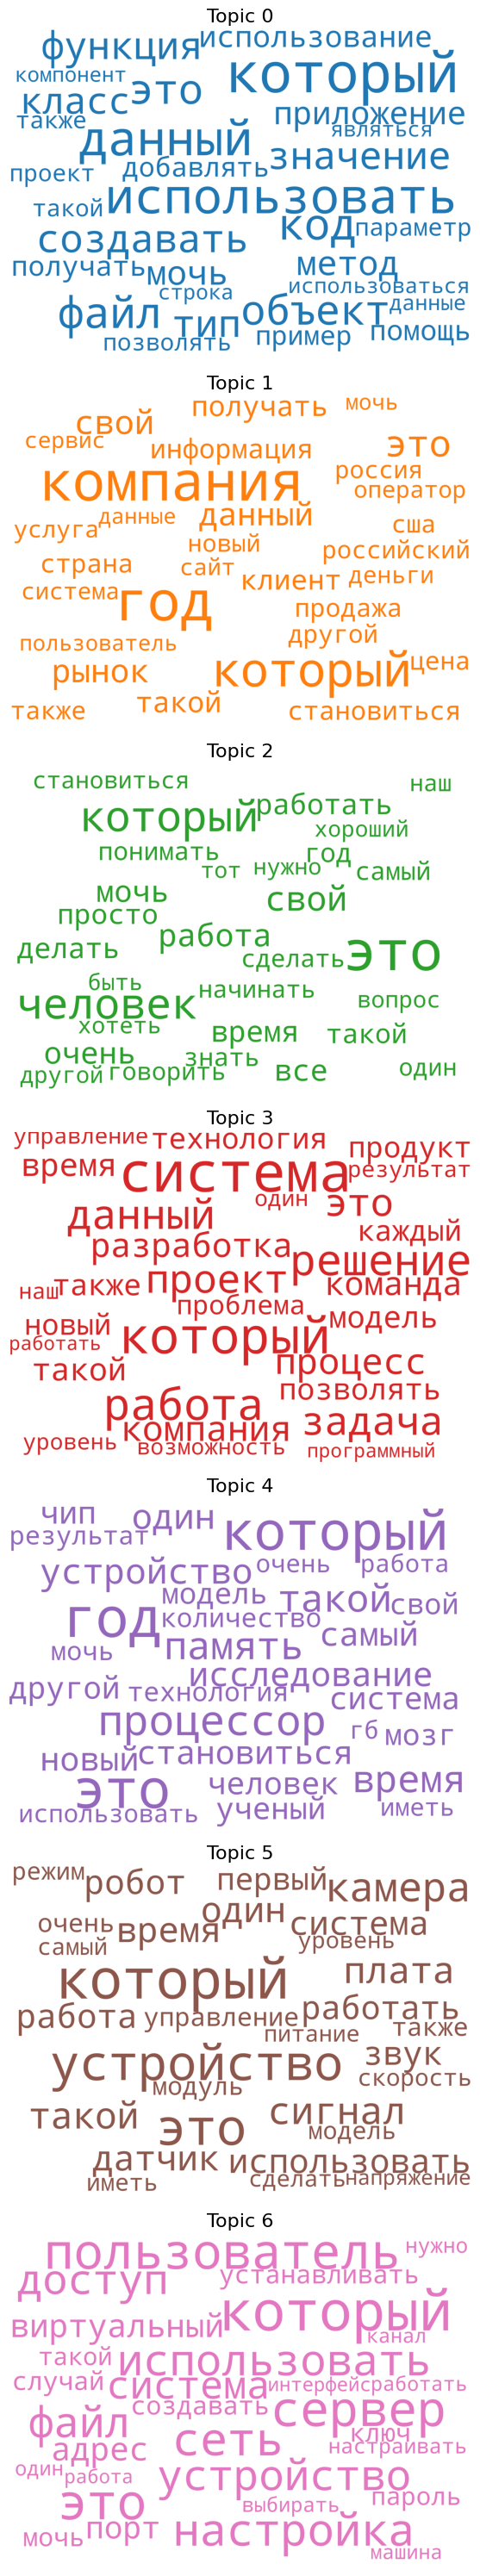

In [140]:
fig, axes = plt.subplots(7, 1, figsize=(50,30), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = {i:abs(k) if abs(k)>0 else 0.0001 for i,k in zip(artm_df.iloc[i,0], artm_df.iloc[i,1])}
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()